In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm

In [3]:
import cv2
from fastai import *
from fastai.vision import *

In [4]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [5]:
np.random.seed(42)

In [6]:
fnames = get_image_files(path, recurse=True)
pat = re.compile(r'^.*(hem|all).bmp$')

In [7]:
size = 224
bs = 64

In [8]:
data  = (ImageDataBunch.from_name_re(path, fnames, pat, size=size, bs=bs, valid_pct=0.1)).normalize()

In [9]:
from torch.autograd import Variable

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class FocalLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.25, gamma=1.):
        super().__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, targ, reduction='none'):
        t = one_hot_embedding(targ, self.num_classes + 1)
        t = Variable(t[:, :-1].contiguous()).cuda()  # .cpu()
        x = pred[:, :-1]
        w = Variable(self.get_weight(x, t))
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes

    def get_weight(self,x,t):
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = self.alpha*t + (1-self.alpha)*(1-t)
        return w * (1-pt).pow(self.gamma)

In [33]:
alphas = np.arange(0.1, 5.0, 0.1)
gammas = np.arange(0.1, 2.0, 0.1)

values = np.zeros((len(gammas), len(alphas)), dtype=np.float)
for i, a in tqdm(enumerate(gammas)):
    for j, g in tqdm(enumerate(alphas)):
        
        gc.collect();
        learn = create_cnn(data, models.resnet34, metrics=[error_rate], loss_func=FocalLoss(num_classes=1, alpha=a, gamma=g))
        learn.to_fp16()
        learn.fit_one_cycle(4, 1e-2)
        
        learn.loss_func = data.loss_func
        interp = ClassificationInterpretation.from_learner(learn)
        
        values[i,j] = int(interp.confusion_matrix().flatten()[[1, 2]].sum()) / len(data.valid_ds.x)


19it [3:05:03, 584.42s/it]

epoch,train_loss,valid_loss,error_rate


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 200, in send_by

KeyboardInterrupt: 

In [35]:
values.shape

(19, 49)

In [13]:
temp_alphas = alphas
temp_gammas = gammas
temp_values = values

temp_values

array([[ 88., 110.,  92.,  66.],
       [315., 307., 298., 350.],
       [351., 351., 351., 351.],
       [351., 351., 351., 351.],
       [351., 351., 351., 351.],
       [351., 351., 351., 351.]])

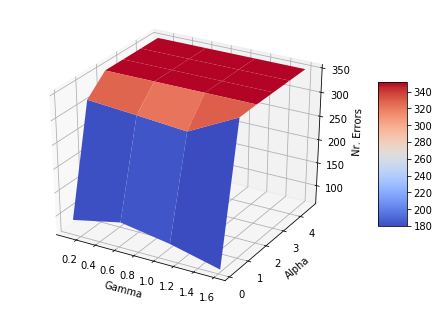

In [21]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()

Xm, Ym = np.meshgrid(temp_alphas, temp_gammas)

ax = Axes3D(plt.gcf())

ax.set_xlabel('Gamma')
ax.set_ylabel('Alpha')
ax.set_zlabel('Nr. Errors')

#ax.set_zlim(50, 100)

surf = ax.plot_surface(Xm, Ym, temp_values, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)


